In [7]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import string
import re
 
%matplotlib inline

from __future__ import print_function
import nltk
import os

# Setup nltk corpora path
nltk_path = os.sep.join([os.environ['HOME'], 'nltk_data'])
nltk.data.path.insert(0, nltk_path)

Define functions that will be used in the notebook:

In [180]:
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(str(text)) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(str(token))
    stems = [str(stemmer.stem(t)) for t in filtered_tokens]
    return stems


def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data, nltk_path=nltk_path):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stop_words
    #sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    
    
    return data

def bigram_gen(data):
    joined_bigrams = []
    for pair in list(nltk.bigrams(data)):
        joined_bigrams.append(' '.join(pair))
    return data+joined_bigrams

from gensim import corpora
def make_corpus(df, token_column_name, filter_above, filter_below):
    dictionary = corpora.Dictionary(df[token_column_name])
    dictionary.filter_extremes(filter_below, filter_above)
    corpus = [dictionary.doc2bow(text) for text in df[token_column_name]]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    return dictionary, corpus

def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for doc in corpus: 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    return doc_topic 

def get_topic_to_wordids(model): 
        p = list() 
        for topicid in range(model.num_topics): 
            topic = model.state.get_lambda()[topicid] 
            topic = topic / topic.sum() # normalize to probability dist 
            p.append(topic) 
        return p 


def get_game_in_groups(corpus, model, num_topics, df):
    group_prediction = get_doc_topic(corpus, model)
    keep = [[x[1] for x in document] for document in group_prediction] 
    column_list = ['topic '+ str(num) for num in range(num_topics)]
    df_group = pd.DataFrame([[x[1] for x in document] for document in group_prediction],columns=column_list)
    df_group['max_group'] = df_group.idxmax(axis =1)
    df_group['index1'] = df_group.index
    df['index1'] = df.index
    df_groups_names = pd.merge(df, df_group, on='index1')
    df_groups_predicted = df_groups_names.groupby('max_group')
    df_check = df_groups_predicted.aggregate(lambda x: tuple(x))
    df_check = df_check.reset_index()
    df_check = df_check[['max_group','name','index1']]
    games_categories = df_check['name']
    for groups in games_categories:
        print(groups) 
        print('\n')
        
    return df_groups_predicted, df_check

Import dataframe and stopwords: 

In [165]:
pkl_filename_master = "df_games.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    df_games = pickle.load(picklefile)

    
pkl_filename_master = "stop_words.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    stop_words= pickle.load(picklefile)

Drop all data but the game descriptions and names:

In [166]:
test_df = df_games.copy().drop([ u'id', u'year_released', u'geek_rating', u'average_rating', 
       u'nrate', u'pic_url', u'url', u'index1', u'min_players', u'max_players', 
     u'category', u'attributes'], axis =1)

Process data, make single word tokens and single word tokens and bigrams to test:

In [167]:
test_df['tokens'] = preprocess_series_text(test_df['description'])

In [168]:
test_df['tokens_w_bigrams'] = test_df.apply(lambda row: bigram_gen(row['tokens']), axis = 1)

Next, make dictionary and corpus (document-term matrix) from tokens using the gensim package. The dictionary function assigns a unique id to each unique token across documents and counts the numbers of each. The dictionary is the key, value pairs of these ids and corresponding words. 
Then, the doc2bow converts each document (each token list in each row) to a bag of words, or a list of tuples containing the token identifier and the number of times it appears in the document (term id, term frequency). 

In [184]:
dictionary, corpus = make_corpus(test_df, 'tokens_w_bigrams', 0.5, 10)


Number of unique tokens: 2340
Number of documents: 1600


In [185]:
print(corpus[2])

[(3, 4), (8, 1), (32, 1), (114, 1), (115, 1), (125, 1), (144, 1), (149, 3), (173, 1), (316, 1), (323, 1), (352, 1), (391, 1), (400, 1), (401, 1), (441, 2), (450, 1), (474, 3), (486, 1), (513, 2), (545, 1), (579, 1), (642, 1), (650, 1), (682, 1), (788, 1), (793, 1), (858, 2), (956, 1), (1088, 1), (1185, 1), (1276, 1), (1302, 1), (1348, 1), (1395, 1), (1396, 1), (1404, 3), (1432, 1), (1451, 2), (1480, 1), (1489, 2), (1500, 1), (1523, 1), (1548, 1), (1562, 1), (1571, 1), (1598, 1), (1606, 1), (1616, 1), (1657, 1), (1720, 1), (1897, 1), (1918, 1), (1934, 1), (2026, 2), (2030, 1), (2048, 6), (2109, 1), (2177, 1), (2209, 1), (2218, 1), (2255, 3), (2291, 1)]


Use Ldamodel to cluster documents through topic modeling. LDA assumes that each document is a mixture of various topics and each topic uses each word with a different frequency. The frequency with which each document uses each word allows it to be grouped into a topic that uses those same words with a similar frequency.  The output of the LDA model is the most probable words to appear in each topic (cluster) and a measure of the frequency at which it appears in that topic (cluster):

In [186]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 12
chunksize = 2000
passes = 10
iterations = 500
eval_every = None  # Model perplexity takes quite a lot of time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is to force Gensim to load the dictionary.
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, 
                       chunksize=chunksize,
                       alpha='auto', 
                       eta='auto',
                       iterations=iterations, 
                       num_topics=num_topics,
                       passes=passes, 
                       eval_every=eval_every)

In [187]:
model_df = pd.DataFrame.from_records(model.show_topics(),columns=['Topic_Number','Word_frequency'])
model_df

,Topic_Number,Word_frequency
0,6,"0.010*""build"" + 0.007*""world"" + 0.006*""dungeon..."
1,8,"0.020*""hero"" + 0.012*""adventure"" + 0.010*""ques..."
2,7,"0.014*""city"" + 0.013*""map"" + 0.013*""train"" + 0..."
3,5,"0.013*""dungeon"" + 0.013*""round"" + 0.009*""trick..."
4,10,"0.021*""build"" + 0.014*""building"" + 0.014*""work..."
5,9,"0.018*""action"" + 0.012*""hand"" + 0.009*""round"" ..."
6,4,"0.035*""tile"" + 0.018*""place"" + 0.011*""round"" +..."
7,1,"0.017*""city"" + 0.014*""building"" + 0.011*""ship""..."
8,0,"0.018*""piece"" + 0.012*""place"" + 0.007*""move"" +..."
9,2,"0.012*""world"" + 0.011*""war"" + 0.007*""control"" ..."


In [188]:
from pprint import pprint
top_topics = model.top_topics(corpus, num_words=10)
pprint(top_topics)

[([(0.01821260037076064, u'action'),
   (0.011750309380368137, u'hand'),
   (0.0089480822498300173, u'round'),
   (0.0088768991116776434, u'move'),
   (0.0077954245727512523, u'value'),
   (0.0072929603537473884, u'four'),
   (0.0068562651312830984, u'place'),
   (0.0068026670219915597, u'play'),
   (0.0067204759073251864, u'color'),
   (0.0064306540719257328, u'set')],
  -60.296516596006086),
 ([(0.020661802496362743, u'build'),
   (0.013850805327492237, u'building'),
   (0.013699978432862981, u'worker'),
   (0.013067460960469951, u'resource'),
   (0.0088837977051013494, u'place'),
   (0.0084529090703565537, u'city'),
   (0.007155453359099795, u'tile'),
   (0.0065437452278597468, u'action'),
   (0.0063396935440432293, u'need'),
   (0.0062660996533763797, u'money')],
  -62.858378431629625),
 ([(0.015611057079572541, u'good'),
   (0.011201959875536103, u'resource'),
   (0.010700876303032899, u'action'),
   (0.009894518819553241, u'build'),
   (0.0098856269984172254, u'ship'),
   (0.0090

This is a cool interactive tool to visualize LDA topics, whether you have independent clusters, and what words overlap between clusters: 

In [189]:
import pyLDAvis, pyLDAvis.gensim
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      14.320552        1       1  0.125267 -0.014951
4      11.348086        1       2 -0.124719  0.069567
9      11.281449        1       3 -0.048851  0.018850
0      10.101400        1       4 -0.008217  0.044414
1       9.662257        1       5  0.009941 -0.034081
11      8.445833        1       6 -0.048702 -0.105456
10      7.298204        1       7 -0.037067 -0.083306
3       6.939248        1       8  0.027679  0.024989
8       6.215079        1       9  0.060719  0.066320
7       5.842841        1      10  0.030026 -0.038032
5       5.824363        1      11  0.007260  0.048501
6       2.720687        1      12  0.006664  0.003187, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
728   Default  949.000000         tile  949.000000  30.0000  30.0000
45    Default  314.000000         hero  314.000000  29.0000  29.0000
1479  Default  795.000000        build  795.000000  28.0000  28.0000
2307  Default  427.000000        piece  427.000000  27.0000  27.0000
852   Default  670.000000         city  670.000000  26.0000  26.0000
1178  Default  540.000000     building  540.000000  25.0000  25.0000
2325  Default  228.000000       worker  228.000000  24.0000  24.0000
955   Default  392.000000     resource  392.000000  23.0000  23.0000
1352  Default  286.000000         good  286.000000  22.0000  22.0000
2092  Default  162.000000      dungeon  162.000000  21.0000  21.0000
549   Default  382.000000          war  382.000000  20.0000  20.0000
571   Default  404.000000         ship  404.000000  19.0000  19.0000
841   Default  193.000000    adventure  193.000000  18.0000  18.0000
1874  Default  134.000000        train  134.000000  17.0000  17.0000
733   Default  257.000000          map  257.000000  16.0000  16.0000
1077  Default  524.000000        world  524.000000  15.0000  15.0000
645   Default  719.000000        round  719.000000  14.0000  14.0000
1910  Default  163.000000       animal  163.000000  13.0000  13.0000
819   Default  304.000000      monster  304.000000  12.0000  12.0000
1264  Default  810.000000       action  810.000000  11.0000  11.0000
940   Default  217.000000     treasure  217.000000  10.0000  10.0000
358   Default  121.000000       pirate  121.000000   9.0000   9.0000
938   Default  498.000000         dice  498.000000   8.0000   8.0000
838   Default  889.000000        place  889.000000   7.0000   7.0000
1053  Default  325.000000        money  325.000000   6.0000   6.0000
1677  Default  135.000000        quest  135.000000   5.0000   5.0000
1014  Default   90.000000        trick   90.000000   4.0000   4.0000
2324  Default  141.000000         star  141.000000   3.0000   3.0000
1337  Default  204.000000        trade  204.000000   2.0000   2.0000
615   Default  361.000000       battle  361.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
2092  Topic12   20.896749      dungeon  162.801415   1.5513  -5.1834
2085  Topic12    8.209945  part series   53.769852   1.7249  -6.1177
2017  Topic12    6.741623          bet   41.874640   1.7779  -6.3147
629   Topic12   12.984192         word  105.084719   1.5133  -5.6593
1605  Topic12   12.676682         fire  109.167784   1.4512  -5.6833
940   Topic12   18.622459     treasure  217.382664   1.1470  -5.2987
2062  Topic12   10.093482         cube   87.823513   1.4408  -5.9112
1479  Topic12   37.212778        build  795.494474   0.5420  -4.6064
1077  Topic12   27.199290        world  524.376220   0.6453  -4.9199
1621  Topic12   11.197984      kingdom  110.676425   1.3134  -5.8073
93    Topic12   11.808590         room  123.783298   1.2546  -5.7542
1449  Topic12   17.870465         part  268.796435   0.8935  -5.3399
1188  Topic12   14.670179     original  201.976225   0.9820  -5.5372
1779  Topic12   19.836668  

And what NLP/clustering project is complete without word clouds! 

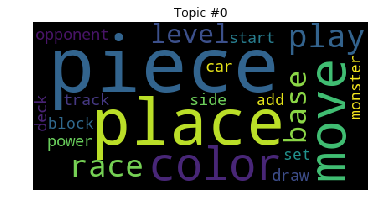

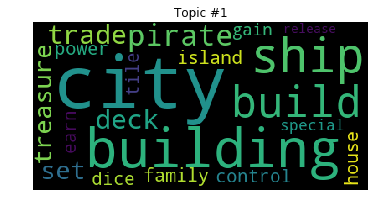

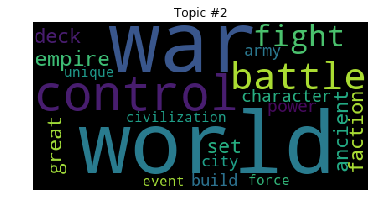

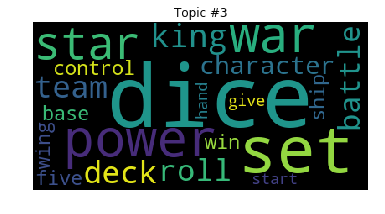

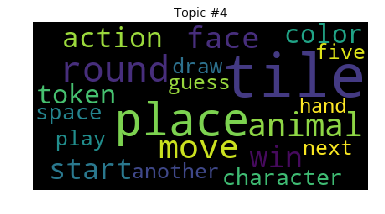

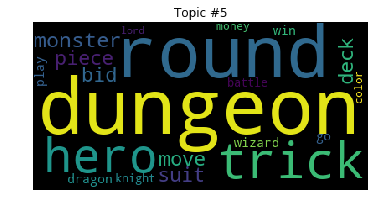

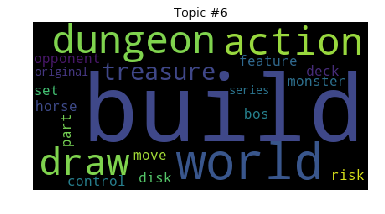

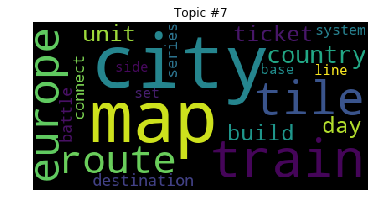

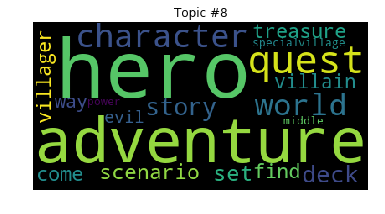

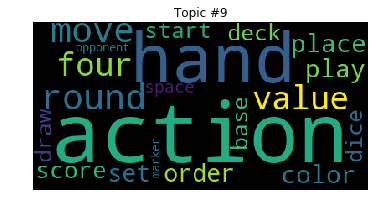

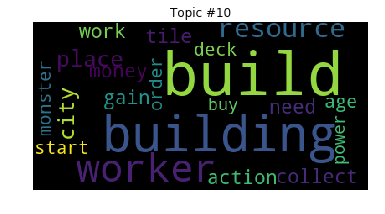

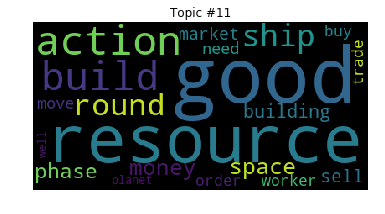

In [190]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 20))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

Knowing the topic clusters is great and all, but its only useful if I can get the game names out of the model to determine similarity and make recommendation.  
The function get_game_in_groups gets a measure of the amount of each topic cluster in each document and finds the most prevalent topic for each document (the maximum). It then traces each document back to the original game title and prints out all the games in each topic cluster.  It also returns a df with the measure of each topic in each document, and a dataframe with each topic, and the games in it.  

In [191]:
df_model, df_check = get_game_in_groups(corpus, model, num_topics, test_df)

(u'Munchkin', u'Hanabi', u'Chess', u'Hive', u'RoboRally', u'Blokus', u'Smash Up', u'No Thanks!', u'Fluxx', u'Battle Line', u'Formula D', u'Catan: Seafarers', u'Qwirkle', u'Neuroshima Hex!', u'Letters from Whitechapel', u'Russian Railroads', u'Backgammon', u'Axis & Allies', u'Rummikub', u'Crokinole', u'PitchCar', u'Jenga', u'Formula D\xe9', u'Legendary Encounters: An Alien Deck Building Game', u'Exploding Kittens', u'Colossal Arena', u'Kahuna', u'The Downfall of Pompeii', u'Battleship', u'Mille Bornes', u'Skull', u'Risk Legacy', u'Checkers', u'Axis & Allies', u'Power Grid: Factory Manager', u'Othello', u'Mr. Jack Pocket', u'Timeline: Inventions', u'Smash Up: Awesome Level 9000', u'Zombie Fluxx', u'Snow Tails', u'Santorini', u'Chrononauts', u'Sequence', u'Kalah', u'Small World: Be Not Afraid...', u'Blood Bowl (Third Edition)', u'Keltis', u'Quoridor', u'Carcassonne: The Tower', u'Sorry!', u'Twilight Imperium (Third Edition): Shattered Empire', u'Blokus Duo', u'Imperial 2030', u'Tash-Kalar

In [192]:
df_model.head(3)

,name,description,tokens,tokens_w_bigrams,index1,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,max_group
0,Catan,"In Catan (formerly The Settlers of Catan), pla...","[formerly, settler, dominant, force, island, b...","[formerly, settler, dominant, force, island, b...",0,0.079344,0.000273,0.000289,0.000226,0.269532,0.000210,0.000160,0.092077,0.000193,0.000262,0.356360,0.201074,topic 10
1,Carcassonne,Carcassonne is a tile-placement game in which ...,"[tile, placement, draw, place, tile, piece, so...","[tile, placement, draw, place, tile, piece, so...",1,0.000652,0.000626,0.000661,0.000519,0.493269,0.000480,0.000367,0.089778,0.000443,0.000599,0.412108,0.000500,topic 4
2,Pandemic,"In Pandemic, several virulent diseases have br...","[several, virulent, disease, break, simultaneo...","[several, virulent, disease, break, simultaneo...",2,0.000591,0.000567,0.386054,0.000470,0.000556,0.000435,0.000332,0.000403,0.000401,0.609294,0.000443,0.000453,topic 9
3,Dominion,(from the back of the box:)&#10;&#10;&quot;You...,"[back, box, monarch, like, parent, ruler, plea...","[back, box, monarch, like, parent, ruler, plea...",3,0.000571,0.818831,0.000579,0.000454,0.000537,0.176539,0.000321,0.000390,0.000388,0.000525,0.000428,0.000438,topic 1
4,7 Wonders,You are the leader of one of the 7 great citie...,"[leader, great, city, ancient, world, gather, ...","[leader, great, city, ancient, world, gather, ...",4,0.000466,0.000447,0.000472,0.000371,0.000438,0.000343,0.000262,0.000318,0.000316,0.000428,0.995783,0.000357,topic 10
5,Ticket to Ride,"With elegantly simple gameplay, Ticket to Ride...","[elegantly, simple, gameplay, learn, minute, p...","[elegantly, simple, gameplay, learn, minute, p...",5,0.112706,0.000492,0.000520,0.000408,0.000483,0.000378,0.000288,0.883128,0.000348,0.000471,0.000384,0.000393,topic 7
6,Agricola,Description from BoardgameNews&#10;&#10;In Agr...,"[boardgamenews, agricola, farmer, wooden, shac...","[boardgamenews, agricola, farmer, wooden, shac...",6,0.227598,0.000435,0.000459,0.000361,0.000427,0.000334,0.000255,0.000309,0.000308,0.419829,0.000339,0.349347,topic 9
7,Puerto Rico,In Puerto Rico players assume the roles of col...,"[puerto, rico, assume, role, colonial, governo...","[puerto, rico, assume, role, colonial, governo...",7,0.000367,0.140529,0.000373,0.000292,0.205411,0.000270,0.000207,0.000251,0.000250,0.000338,0.000275,0.651437,topic 11
8,Small World,"In Small World, players vie for conquest and c...","[world, vie, conquest, control, world, simply,...","[world, vie, conquest, control, world, simply,...",8,0.000493,0.000473,0.699093,0.000392,0.297038,0.000363,0.000277,0.000336,0.000335,0.000453,0.000369,0.000378,topic 2
9,Power Grid,Power Grid is the updated release of the Fried...,"[power, grid, update, release, friedemann, fri...","[power, grid, update, release, friedemann, fri...",9,0.000523,0.000503,0.000531,0.664024,0.000493,0.000385,0.000294,0.000357,0.000356,0.000481,0.000392,0.331661,topic 3


In [193]:
df_check.head(12)

,max_group,name,index1
0,topic 0,"(Munchkin, Hanabi, Chess, Hive, RoboRally, Blo...","(21, 30, 44, 46, 50, 68, 72, 94, 120, 122, 124..."
1,topic 1,"(Dominion, Citadels, Lords of Waterdeep, Forbi...","(3, 10, 20, 24, 35, 39, 57, 63, 74, 76, 91, 11..."
2,topic 10,"(Catan, 7 Wonders, King of Tokyo, Stone Age, S...","(0, 4, 11, 16, 19, 36, 37, 40, 52, 62, 64, 79,..."
3,topic 11,"(Puerto Rico, Race for the Galaxy, Android: Ne...","(7, 14, 41, 53, 55, 59, 67, 75, 85, 95, 108, 1..."
4,topic 2,"(Small World, Arkham Horror, Twilight Struggle...","(8, 17, 23, 27, 29, 32, 33, 42, 54, 66, 71, 73..."
5,topic 3,"(Power Grid, Codenames, The Resistance, Risk, ...","(9, 18, 26, 34, 69, 78, 137, 163, 192, 206, 21..."
6,topic 4,"(Carcassonne, Dixit, The Castles of Burgundy, ...","(1, 15, 28, 38, 45, 48, 56, 70, 82, 83, 92, 97..."
7,topic 5,"(Monopoly, Mage Knight Board Game, Ra, Survive...","(49, 60, 77, 102, 139, 156, 168, 172, 200, 225..."
8,topic 6,"(Love Letter, Takenoko, Flash Point: Fire Resc...","(12, 47, 99, 106, 170, 223, 241, 314, 373, 477..."
9,topic 7,"(Ticket to Ride, Ticket to Ride: Europe, Memoi...","(5, 13, 51, 86, 87, 88, 154, 180, 191, 233, 23..."
